# Sea Level: Permanent Service of Mean Sea Level 
Notebook for analysing tide measurement data for 1490 tide gauges worldwide. I use the Revised Local Reference (RLR) data set. The RLR datum is set to 7000 mm below mean sea level therefore the values are all in the range of 6000 to 8000 mm.

All UK tide gauge data is included in the PSMSL data set, most of the data from the University of Hawaii is included as well.

Data source is Permanent Service of Mean Sea Level (http://www.psmsl.org/data/obtaining/complete.php, RLR monthly)

Data set with monthly mean data.

Data has been obtained on 10 February 2017.

## Load libraries

In [1]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

#get data from worldbank
from pandas_datareader import wb

import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import json
import matplotlib.pyplot as plt

#create leaflet maps
import folium

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_rows = 200
#matplotlib.rcParams['svg.fonttype'] = 'none'


## Setup the data
### First: Read meta data for all stations of PSMSL

In [2]:
#parse errorflags
stations_errorflag = 'data/psmsl_data/filelist.txt'

errors = pd.read_csv(stations_errorflag, sep=';', header=None, usecols=[0, 6], names=['id', 'latitude', 'longitude', 'locataion', 'coastline', 'station', 'flag' ])

#parse meta data
meta_info = 'data/metadata_psmsl.csv'

stations = pd.read_csv(meta_info, header=0, names=['location', 'ID', 'latitude', 'longitude', 'gloss id', 'country', 'date', 'coastline', 'station'])

#comibe meta data and error flags
stations = stations.merge(errors, left_on='ID', right_on='id')

stations = stations.drop('ID', 1)

len(errors)
len(stations)

stations.head()

1490

1490

location  latitude  longitude  gloss id country  \
0                     REYKJAVIK    64.151    -21.940     229.0     ISL   
1                     GRINDAVIK    63.833    -22.433       NaN     ISL   
2                      TORSHAVN    62.017     -6.767     237.0     FRO   
3                   BARENTSBURG    78.067     14.250     231.0     SJM   
4  BARENTSBURG II (SPITSBERGEN)    78.067     14.250     231.0     SJM   

         date  coastline  station   id flag  
0  24/01/2017         10        1  638    N  
1  01/01/1980         10       11  877    N  
2  30/10/2007         15       11  839    N  
3  17/01/2017         25        1  541    N  
4  17/01/2003         25        2  547    N

In [3]:
#convert capitals to lowercase with a capitalized first letter
def convert_location_names(str):
    conversion = str.title()
    return conversion

stations['location'] = stations['location'].apply(convert_location_names)

In [20]:
coordinates = list(zip(data_subset_viz['latitude'], data_subset_viz['longitude']))


### Second: Read all the tide data from folder

In [4]:
#parse file

def parse_tides(filename):
    filepath = 'data/psmsl_data/' + str(filename) + '.rlrdata'
    df = pd.read_csv(filepath, sep=';', header=None, names=['year-month', 'tide', 'missing day', 'flag for attention'])

    df['flag for attention'] = df['flag for attention'].apply(lambda x: '{0:0>3}'.format(x))
    df['year'] = df['year-month'].apply(np.floor).astype('int')
    df['month'] = ((((df['year-month'] - df['year'])*24)+1)/2).apply(np.around).astype('int')
    df['day'] = 1 #due the monthly averages, no days are present, set days to 1
    df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')
    df['ID'] = filename
    df['ID'] = df['ID'].astype('int')

    df = df.drop('year-month', 1)
    df = df.drop('year', 1)
    df = df.drop('month', 1)
    df = df.drop('day', 1)
    
    #print (filepath)
    
    return df

#filepath for complete tide data set
filepath = 'data/psmsl_data/tideData_psmsl_complete.csv'

if os.path.exists(filepath):
    df = pd.read_csv(filepath, usecols=[1,2,3,4,5])
    df['flag for attention'] = df['flag for attention'].apply(lambda x: '{0:0>3}'.format(x))
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
else:
    df = pd.concat([parse_tides(f) for f in stations['id']])
    #replace null values
    df['tide'] = df['tide'].replace("-99999",np.nan)
    df.to_csv(filepath)

df['ID'].nunique()
df.head()

1490

tide  missing day flag for attention  timestamp   ID
0  6980.0            0                000 1956-05-01  638
1  6840.0            0                000 1956-06-01  638
2  6890.0            0                000 1956-07-01  638
3  6830.0            0                000 1956-08-01  638
4  6830.0            0                000 1956-09-01  638

### Third: Merge meta data and tide data

In [5]:
df = df.merge(stations, left_on='ID', right_on='id')

df = df.drop('id', 1)

df['ID'].nunique()
df.head()


1490

tide  missing day flag for attention  timestamp   ID   location  \
0  6980.0            0                000 1956-05-01  638  Reykjavik   
1  6840.0            0                000 1956-06-01  638  Reykjavik   
2  6890.0            0                000 1956-07-01  638  Reykjavik   
3  6830.0            0                000 1956-08-01  638  Reykjavik   
4  6830.0            0                000 1956-09-01  638  Reykjavik   

   latitude  longitude  gloss id country        date  coastline  station flag  
0    64.151     -21.94     229.0     ISL  24/01/2017         10        1    N  
1    64.151     -21.94     229.0     ISL  24/01/2017         10        1    N  
2    64.151     -21.94     229.0     ISL  24/01/2017         10        1    N  
3    64.151     -21.94     229.0     ISL  24/01/2017         10        1    N  
4    64.151     -21.94     229.0     ISL  24/01/2017         10        1    N

In [6]:
len(df)

703599

In [7]:
df.to_csv('data/psmsl_data_complete_including_metadata.csv')

## Add continent data

In [9]:
continents = pd.read_csv('context_data/continents.csv')

worldbank_data = continents.merge(worldbank_data, left_on='iso3', right_on='iso3')

worldbank_data

continent iso3    ID   emission           gdp          pop  \
0        Antarctica  ATA   988        NaN           NaN          NaN   
1        Antarctica  ATA   913        NaN           NaN          NaN   
2        Antarctica  ATA  1603        NaN           NaN          NaN   
3        Antarctica  ATA   858        NaN           NaN          NaN   
4        Antarctica  ATA  1763        NaN           NaN          NaN   
5        Antarctica  ATA  2029        NaN           NaN          NaN   
6        Antarctica  ATA  1931        NaN           NaN          NaN   
7           Oceania  ASM   539        NaN           NaN      55538.0   
8     South America  ARG   874   4.462298  5.831686e+11   43416755.0   
9     South America  ARG  1271   4.462298  5.831686e+11   43416755.0   
10    South America  ARG   185   4.462298  5.831686e+11   43416755.0   
11    South America  ARG   181   4.462298  5.831686e+11   43416755.0   
12    South America  ARG   501   4.462298  5.831686e+11   43416755.0   
13    South America  ARG   867   4.462298  5.831686e+11   43416755.0   
14    South America  ARG   870   4.462298  5.831686e+11   43416755.0   
15    South America  ARG   223   4.462298  5.831686e+11   43416755.0   
16    South America  ARG   857   4.462298  5.831686e+11   43416755.0   
17    South America  ARG   819   4.462298  5.831686e+11   43416755.0   
18    South America  ARG  1542   4.462298  5.831686e+11   43416755.0   
19    South America  ARG   897   4.462298  5.831686e+11   43416755.0   
20    South America  ARG   157   4.462298  5.831686e+11   43416755.0   
21    South America  ARG   832   4.462298  5.831686e+11   43416755.0   
22    South America  ARG   864   4.462298  5.831686e+11   43416755.0   
23          Oceania  AUS   935  16.347302  1.339141e+12   23781169.0   
24          Oceania  AUS  1160  16.347302  1.339141e+12   23781169.0   
25          Oceania  AUS   835  16.347302  1.339141e+12   23781169.0   
26          Oceania  AUS  1157  16.347302  1.339141e+12   23781169.0   
27          Oceania  AUS  1268  16.347302  1.339141e+12   23781169.0   
28          Oceania  AUS  1749  16.347302  1.339141e+12   23781169.0   
29          Oceania  AUS  1471  16.347302  1.339141e+12   23781169.0   
30          Oceania  AUS   953  16.347302  1.339141e+12   23781169.0   
31          Oceania  AUS  1629  16.347302  1.339141e+12   23781169.0   
32          Oceania  AUS  1630  16.347302  1.339141e+12   23781169.0   
33          Oceania  AUS  2074  16.347302  1.339141e+12   23781169.0   
34          Oceania  AUS   637  16.347302  1.339141e+12   23781169.0   
35          Oceania  AUS  1492  16.347302  1.339141e+12   23781169.0   
36          Oceania  AUS  1569  16.347302  1.339141e+12   23781169.0   
37          Oceania  AUS   564  16.347302  1.339141e+12   23781169.0   
38          Oceania  AUS  1760  16.347302  1.339141e+12   23781169.0   
39          Oceania  AUS  2072  16.347302  1.339141e+12   23781169.0   
40          Oceania  AUS   825  16.347302  1.339141e+12   23781169.0   
41          Oceania  AUS  1154  16.347302  1.339141e+12   23781169.0   
42          Oceania  AUS   822  16.347302  1.339141e+12   23781169.0   
43          Oceania  AUS   319  16.347302  1.339141e+12   23781169.0   
44          Oceania  AUS  2310  16.347302  1.339141e+12   23781169.0   
45          Oceania  AUS  2314  16.347302  1.339141e+12   23781169.0   
46          Oceania  AUS  2319  16.347302  1.339141e+12   23781169.0   
47          Oceania  AUS   821  16.347302  1.339141e+12   23781169.0   
48          Oceania  AUS  1229  16.347302  1.339141e+12   23781169.0   
49          Oceania  AUS   310  16.347302  1.339141e+12   23781169.0   
50          Oceania  AUS   799  16.347302  1.339141e+12   23781169.0   
51          Oceania  AUS  2311  16.347302  1.339141e+12   23781169.0   
52          Oceania  AUS   818  16.347302  1.339141e+12   23781169.0   
53          Oceania  AUS  2313  16.347302  1.339141e+12   23781169.0   
54          Oceania  AUS  2316  16.347302  1.33914

### Filter data by quality flags

Data flagged for attention: 001 means data should be treated with caution, 010 indicates a mean tidal level (MTL) value in a mean sea level (MSL) time series

In [8]:
df.flag = df.flag.str.strip()

df['missing day'] = df['missing day'].replace("99",np.nan)

data_flagged = df[(df['flag for attention'] == '011')]

#data_flagged.sort_values('missing day', ascending=False)

data_without_flag = df[df['flag for attention'].isin(['001', '011']) == False]
#data_without_flag = df[df['flag for attention'].isin(['011']) == False]

#data_without_flag.sort_values('flag for attention')

data_without_flag.shape
df.shape

#89 Location sind geflaggt mit 001 und eine Location mit 011, gesamte Anzahl Locations 1478


(701692, 14)

(703599, 14)

In [9]:
df = data_without_flag

In [10]:
data_flagged = df[(df['flag for attention'] == '011')]
data_flagged

Empty DataFrame
Columns: [tide, missing day, flag for attention, timestamp, ID, location, latitude, longitude, gloss id, country, date, coastline, station, flag]
Index: []

## Analysis

In [13]:
first_measurement = df.groupby(['location', 'country']).timestamp.first()
stations_1900 = first_measurement[first_measurement.dt.year <= 1900]
stations_1925 = first_measurement[first_measurement.dt.year <= 1925]
stations_1950 = first_measurement[first_measurement.dt.year <= 1950] 
stations_1975 = first_measurement[first_measurement.dt.year <= 1975]
stations_1990 = first_measurement[first_measurement.dt.year <= 1990]
stations_2000 = first_measurement[first_measurement.dt.year <= 2000]
stations_2010 = first_measurement[first_measurement.dt.year <= 2010]
stations_2014 = first_measurement[first_measurement.dt.year <= 2014]
# stations_1970
#first_measurement.sort_values()
stations_1900.sort_values().head(20)

stations_hist = pd.Series([len(stations_1900), len(stations_1925), len(stations_1950), len(stations_1975), len(stations_2000), len(stations_2014)],
                          index=['<1900', '<1925', '<1950', '<1975', '<2000', '<2014'])

stations_hist

#first_measurement.dt.year

location                             country
Brest                                FRA       1807-01-01
Swinoujscie                          POL       1811-01-01
Sheerness                            GBR       1832-04-01
Cuxhaven 2                           DEU       1843-01-01
Maassluis                            NLD       1848-01-01
Wismar 2                             DEU       1848-07-01
San Francisco                        USA       1854-07-01
Warnemunde 2                         DEU       1855-04-01
New York (The Battery)               USA       1856-01-01
Travemunde                           DEU       1856-01-01
Lyokki                               FIN       1858-01-01
Jungfrusund                          FIN       1858-01-01
Liverpool Georges And Princes Piers  GBR       1858-01-01
Lypyrtti                             FIN       1858-01-01
Aberdeen Ii                          GBR       1862-01-01
Vlissingen                           NLD       1862-01-01
Hoek Van Holland           

<1900      96
<1925     177
<1950     400
<1975     961
<2000    1321
<2014    1490
dtype: int64

In [14]:
first_measurement = df.groupby(['location', 'country']).timestamp.first()
last_measurement = df.groupby(['location', 'country']).timestamp.last()

#stations_2010 = first_measurement[first_measurement.dt.year <= 2010]
#stations_2014 = first_measurement[first_measurement.dt.year <= 2014]
last_measurement.head()

location     country
Aarhus       DNK       2012-12-01
Abashiri     JPN       2015-12-01
Aberdeen I   GBR       2015-04-01
Aberdeen Ii  GBR       1965-12-01
Abidjan      CIV       1976-03-01
Name: timestamp, dtype: datetime64[ns]

### Create subsets of the data


In [13]:
#function that evaluates how many empty values a station has and start and end of each station

def empty_values(dataframe):
    
    station = dataframe.set_index('timestamp').tide.resample('1A').mean()
    
    first_year = station.first_valid_index().year
    last_year = station.last_valid_index().year
    count_missing = station.isnull().sum()
    count_values = station.count()
    
    
    #tide_first = station.iloc[0]
    #station = station.sort_values(ascending=False)
    #tide_last = station.iloc[0]
    #tide_change = tide_last - tide_first
    
    result = {}

    result['Start'] = first_year
    result['End'] = last_year
    result['Valid Data Points'] = count_values
    result['Missing Data Points'] = count_missing
    
    return pd.Series(result) #create a series


#call function and collect all data
#clean_data = df.groupby(['Location', 'Country']).apply(empty_values).sort_values('Valid Data Points', ascending=False)

#clean_data = df.groupby(['ID']).apply(empty_values).sort_values('Valid Data Points', ascending=False)


#reset index

#clean_data = clean_data.reset_index()


In [11]:
data_subset_1985_2014 = df.set_index(['timestamp'])

data_subset_1985_2014 = data_subset_1985_2014.loc['1985-01-01':'2014-12-01']

data_subset_1985_2014 = data_subset_1985_2014.reset_index()

In [14]:
clean_data = data_subset_1985_2014.groupby(['ID']).apply(empty_values).sort_values('Valid Data Points', ascending=False)

clean_data = clean_data.reset_index()

data_subset_1985_2014_clean = clean_data[(clean_data['Start'] <= 1985)
                               & (clean_data['Valid Data Points'] >= 21) 
                               & (clean_data['End'] >= 2010) ]
data_subset_1985_2014_clean
data_subset_1985_2014_clean['ID'].nunique()

ID   End  Missing Data Points  Start  Valid Data Points
0       1  2014                    0   1985                 30
1    1246  2014                    0   1985                 30
2    1242  2014                    0   1985                 30
3    1244  2014                    0   1985                 30
4     523  2014                    0   1985                 30
5     522  2014                    0   1985                 30
6     521  2014                    0   1985                 30
7     520  2014                    0   1985                 30
8    1245  2014                    0   1985                 30
9     518  2014                    0   1985                 30
10    513  2014                    0   1985                 30
11    510  2014                    0   1985                 30
12    489  2014                    0   1985                 30
13    509  2014                    0   1985                 30
14    508  2014                    0   1985                 30
15   1247  2014                    0   1985                 30
16   1252  2014                    0   1985                 30
17    499  2014                    0   1985                 30
18    498  2014                    0   1985                 30
19    497  2014                    0   1985                 30
20   1253  2014                    0   1985                 30
21   1263  2014                    0   1985                 30
22    526  2014                    0   1985                 30
23   1241  2014                    0   1985                 30
24   1239  2014                    0   1985                 30
25    538  2014                    0   1985                 30
26    595  2014                    0   1985                 30
27   1157  2014                    0   1985                 30
28   1158  2014                    0   1985                 30
29    567  2014                    0   1985                 30
30    566  2014                    0   1985                 30
31   1193  2014                    0   1985                 30
32    564  2014                    0   1985                 30
33    563  2014                    0   1985                 30
34   1209  2014                    0   1985                 30
35   1210  2014                    0   1985                 30
36   1211  2014                    0   1985                 30
37   1212  2014                    0   1985                 30
38   1213  2014                    0   1985                 30
39   1233  2014                    0   1985                 30
40   1234  2014                    0   1985                 30
41   1236  2014                    0   1985                 30
42    541  2014                    0   1985                 30
43   1237  2014                    0   1985                 30
44    539  2014                    0   1985                 30
45   1264  2014                    0   1985                 30
46   1265  2014                    0   1985                 30
47    394  2014                    0   1985                 30
48    412  2014                    0   1985                 30
49    431  2014                    0   1985                 30
50    430  2014                    0   1985                 30
51    429  2014                    0   1985                 30
52   1328  2014                    0   1985                 30
53    427  2014                    0   1985                 30
54    426  2014                    0   1985                 30
55   1347  2014                    0   1985                 30
56   1349  2014                    0   1985                 30
57    413  2014                    0   1985                 30
58   1351  2014                    0   1985                 30
59    487  2014                    0   1985                 30
60    808  2014                    0   1985                 30
61   1353  2014                    0   1985                 30
62   1354  2014                    0  

509

In [ ]:
data_subset_1930_2010 = clean_data[(clean_data['Start'] <= 1930)
                               & (clean_data['Missing Data Points'] <= 20) 
                               & (clean_data['End'] >= 2010) ]

data_subset_1950_2010 = clean_data[(clean_data['Start'] <= 1950)
                               & (clean_data['Missing Data Points'] <= 20) 
                               & (clean_data['End'] >= 2010) ]

data_subset_1985_2014 = clean_data[(clean_data['Start'] <= 1970)
                               & (clean_data['Missing Data Points'] <= 20) 
                               & (clean_data['End'] >= 2010) ]

In [15]:
data_subset_1985_2014_clean = data_subset_1985_2014_clean.merge(df, left_on='ID', right_on='ID')

In [21]:
#Merge dataset with meta data an save to csv

data_subset_1930_2010 = data_subset_1930_2010.merge(df, left_on='ID', right_on='ID')
data_subset_1950_2010 = data_subset_1950_2010.merge(df, left_on='ID', right_on='ID')
data_subset_1970_2010 = data_subset_1970_2010.merge(df, left_on='ID', right_on='ID')

#data_subset_1930_2010.to_csv('data/data_subset_1930_2010_psmsl.csv', encoding='utf-8') #103 locations
#data_subset_1950_2010.to_csv('data/data_subset_1950_2010_psmsl.csv', encoding='utf-8') #188 locations
#data_subset_1970_2010.to_csv('data/data_subset_1970_2010_psmsl.csv', encoding='utf-8') #395 locations

data_subset_1930_2010.head()

ID   End  Missing Data Points  Start  Valid Data Points    tide  \
0   1  2015                   19   1807                190  6905.0   
1   1  2015                   19   1807                190  6931.0   
2   1  2015                   19   1807                190  6896.0   
3   1  2015                   19   1807                190  6953.0   
4   1  2015                   19   1807                190  7043.0   

   missing day flag for attention  timestamp Location  Latitude  Longitude  \
0          0.0                010 1807-01-01    Brest    48.383     -4.495   
1          0.0                010 1807-02-01    Brest    48.383     -4.495   
2          0.0                010 1807-03-01    Brest    48.383     -4.495   
3          0.0                010 1807-04-01    Brest    48.383     -4.495   
4          0.0                010 1807-05-01    Brest    48.383     -4.495   

   GLOSS ID Country        Date  Coastline  Station Flag  
0     242.0     FRA  30/08/2016        190       91    N  
1     242.0     FRA  30/08/2016        190       91    N  
2     242.0     FRA  30/08/2016        190       91    N  
3     242.0     FRA  30/08/2016        190       91    N  
4     242.0     FRA  30/08/2016        190       91    N

### Calculate Sea Level Rise

In [22]:
#function that creates a mean of first 5 years and last 5 years and then calculates the difference and percentage

def sealevel_rise(dataframe):
    
    station = dataframe.set_index('timestamp').tide.resample('1A').mean()
    
    first = station[:5].mean() 
    last = station[-5:].mean()
    increase = last - first
    pct_change = (increase / first) * 100
    
    result = {}

    result['First'] = first
    result['Last'] = last
    result['Percent Change'] = pct_change
    
    #significant increase if more than 0.5%, significant decrease if less than -0.5%, check with scientist
    
    if pct_change >= 0.5:
        result['rise'] = 'up'
    elif (pct_change < 0.5 and pct_change > -0.5):
        result['rise']  = 'even'
    elif pct_change <= -0.5:
        result['rise'] = 'down'
    else:
        result['rise'] = 'none'
        
    return pd.Series(result) #create a series


In [16]:
#this function uses sealevel rise function and and saves the results to a file

def stations_change(dataframe, name):
    
    filename = name
    
    result = dataframe.groupby(['ID']).apply(sealevel_rise)
    result['rise'] = result['rise'].astype('category')
    
    #reset index
    result = result.reset_index()
    
    result = result.merge(stations, left_on='ID', right_on='id')
    
    result.to_csv('data/subsets' + name + '_rise_psmsl.csv', encoding='utf-8')
    
    return result

In [24]:
# at least 1970, but also older data

data_subset_1970_rise = stations_change(data_subset_1970_2010, 'data_subset_1970_2010')

data_subset_1970_rise.head()

data_subset_1970_rise['rise'].value_counts()

ID        First         Last  Percent Change rise    Location  Latitude  \
0   1  6943.233333  7139.430303        2.825729   up       Brest    48.383   
1   5  6934.850000  7083.570000        2.144531   up    Holyhead    53.314   
2   7  6822.250000  7149.583333        4.798026   up  Cuxhaven 2    53.867   
3   8  6897.683333  7093.300000        2.835976   up    Wismar 2    53.899   
4   9  6690.750000  6946.533333        3.822940   up   Maassluis    51.918   

   Longitude  GLOSS ID Country        Date  Coastline  Station  id Flag  
0     -4.495     242.0     FRA  30/08/2016        190       91   1    N  
1     -4.620       NaN     GBR  31/05/2016        170      191   5    Y  
2      8.717     284.0     DEU  27/01/2016        140       12   7    N  
3     11.458       NaN     DEU  18/11/2015        120       22   8    N  
4      4.250       NaN     NLD  14/06/2016        150       61   9    N

up      279
down     66
even     50
Name: rise, dtype: int64

#### Subset 1970 to 2010 only

In [25]:
data_subset = data_subset_1970_2010.set_index(['timestamp'])

data_subset_1970_only = data_subset.loc['1970-01-01':'2016-01-01']

data_subset_1970_only = data_subset_1970_only.reset_index()

data_subset_1970_only.head()

timestamp  ID   End  Missing Data Points  Start  Valid Data Points    tide  \
0 1970-01-01   1  2015                   19   1807                190  7250.0   
1 1970-02-01   1  2015                   19   1807                190  7096.0   
2 1970-03-01   1  2015                   19   1807                190  6989.0   
3 1970-04-01   1  2015                   19   1807                190  6983.0   
4 1970-05-01   1  2015                   19   1807                190  6971.0   

   missing day flag for attention Location  Latitude  Longitude  GLOSS ID  \
0          0.0                000    Brest    48.383     -4.495     242.0   
1          0.0                000    Brest    48.383     -4.495     242.0   
2          0.0                000    Brest    48.383     -4.495     242.0   
3          0.0                000    Brest    48.383     -4.495     242.0   
4          0.0                000    Brest    48.383     -4.495     242.0   

  Country        Date  Coastline  Station Flag  
0     FRA  30/08/2016        190       91    N  
1     FRA  30/08/2016        190       91    N  
2     FRA  30/08/2016        190       91    N  
3     FRA  30/08/2016        190       91    N  
4     FRA  30/08/2016        190       91    N

In [26]:
# from 1970 onwards only
data_subset_1970 = stations_change(data_subset_1970_only, 'only_1970_2010')

data_subset_1970['rise'].value_counts()

up      277
even     61
down     53
none      4
Name: rise, dtype: int64

In [27]:
data_subset_plot = data_subset_1970_2010.groupby(['Location', 'timestamp']).tide.mean().unstack().T

data_subset_plot = data_subset_plot.resample("5A").mean().apply(np.round)

data_subset_plot.head()


Location    Aarhus  Abashiri  Aberdeen I  Aburatsu  Aburatsubo  Acapulco  \
timestamp                                                                  
1807-12-31     NaN       NaN         NaN       NaN         NaN       NaN   
1812-12-31     NaN       NaN         NaN       NaN         NaN       NaN   
1817-12-31     NaN       NaN         NaN       NaN         NaN       NaN   
1822-12-31     NaN       NaN         NaN       NaN         NaN       NaN   
1827-12-31     NaN       NaN         NaN       NaN         NaN       NaN   

Location    Adak Sweeper Cove  Akune  Alameda (Naval Air Station)  Alesund  \
timestamp                                                                    
1807-12-31                NaN    NaN                          NaN      NaN   
1812-12-31                NaN    NaN                          NaN      NaN   
1817-12-31                NaN    NaN                          NaN      NaN   
1822-12-31                NaN    NaN                          NaN      NaN   
1827-12-31                NaN    NaN                          NaN      NaN   

Location    ...    Wick  Wilmington  Wismar 2  Woods Hole (Ocean. Inst.)  \
timestamp   ...                                                            
1807-12-31  ...     NaN         NaN       NaN                        NaN   
1812-12-31  ...     NaN         NaN       NaN                        NaN   
1817-12-31  ...     NaN         NaN       NaN                        NaN   
1822-12-31  ...     NaN         NaN       NaN                        NaN   
1827-12-31  ...     NaN         NaN       NaN                        NaN   

Location    Yakutat  Yarmouth  Yeosu  Yokosuka  Zeebrugge  Zhapo  
timestamp                                                         
1807-12-31      NaN       NaN    NaN       NaN        NaN    NaN  
1812-12-31      NaN       NaN    NaN       NaN        NaN    NaN  
1817-12-31      NaN       NaN    NaN       NaN        NaN    NaN  
1822-12-31      NaN       NaN    NaN       NaN        NaN    NaN  
1827-12-31      NaN       NaN    NaN       NaN        NaN    NaN  

[5 rows x 395 columns]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


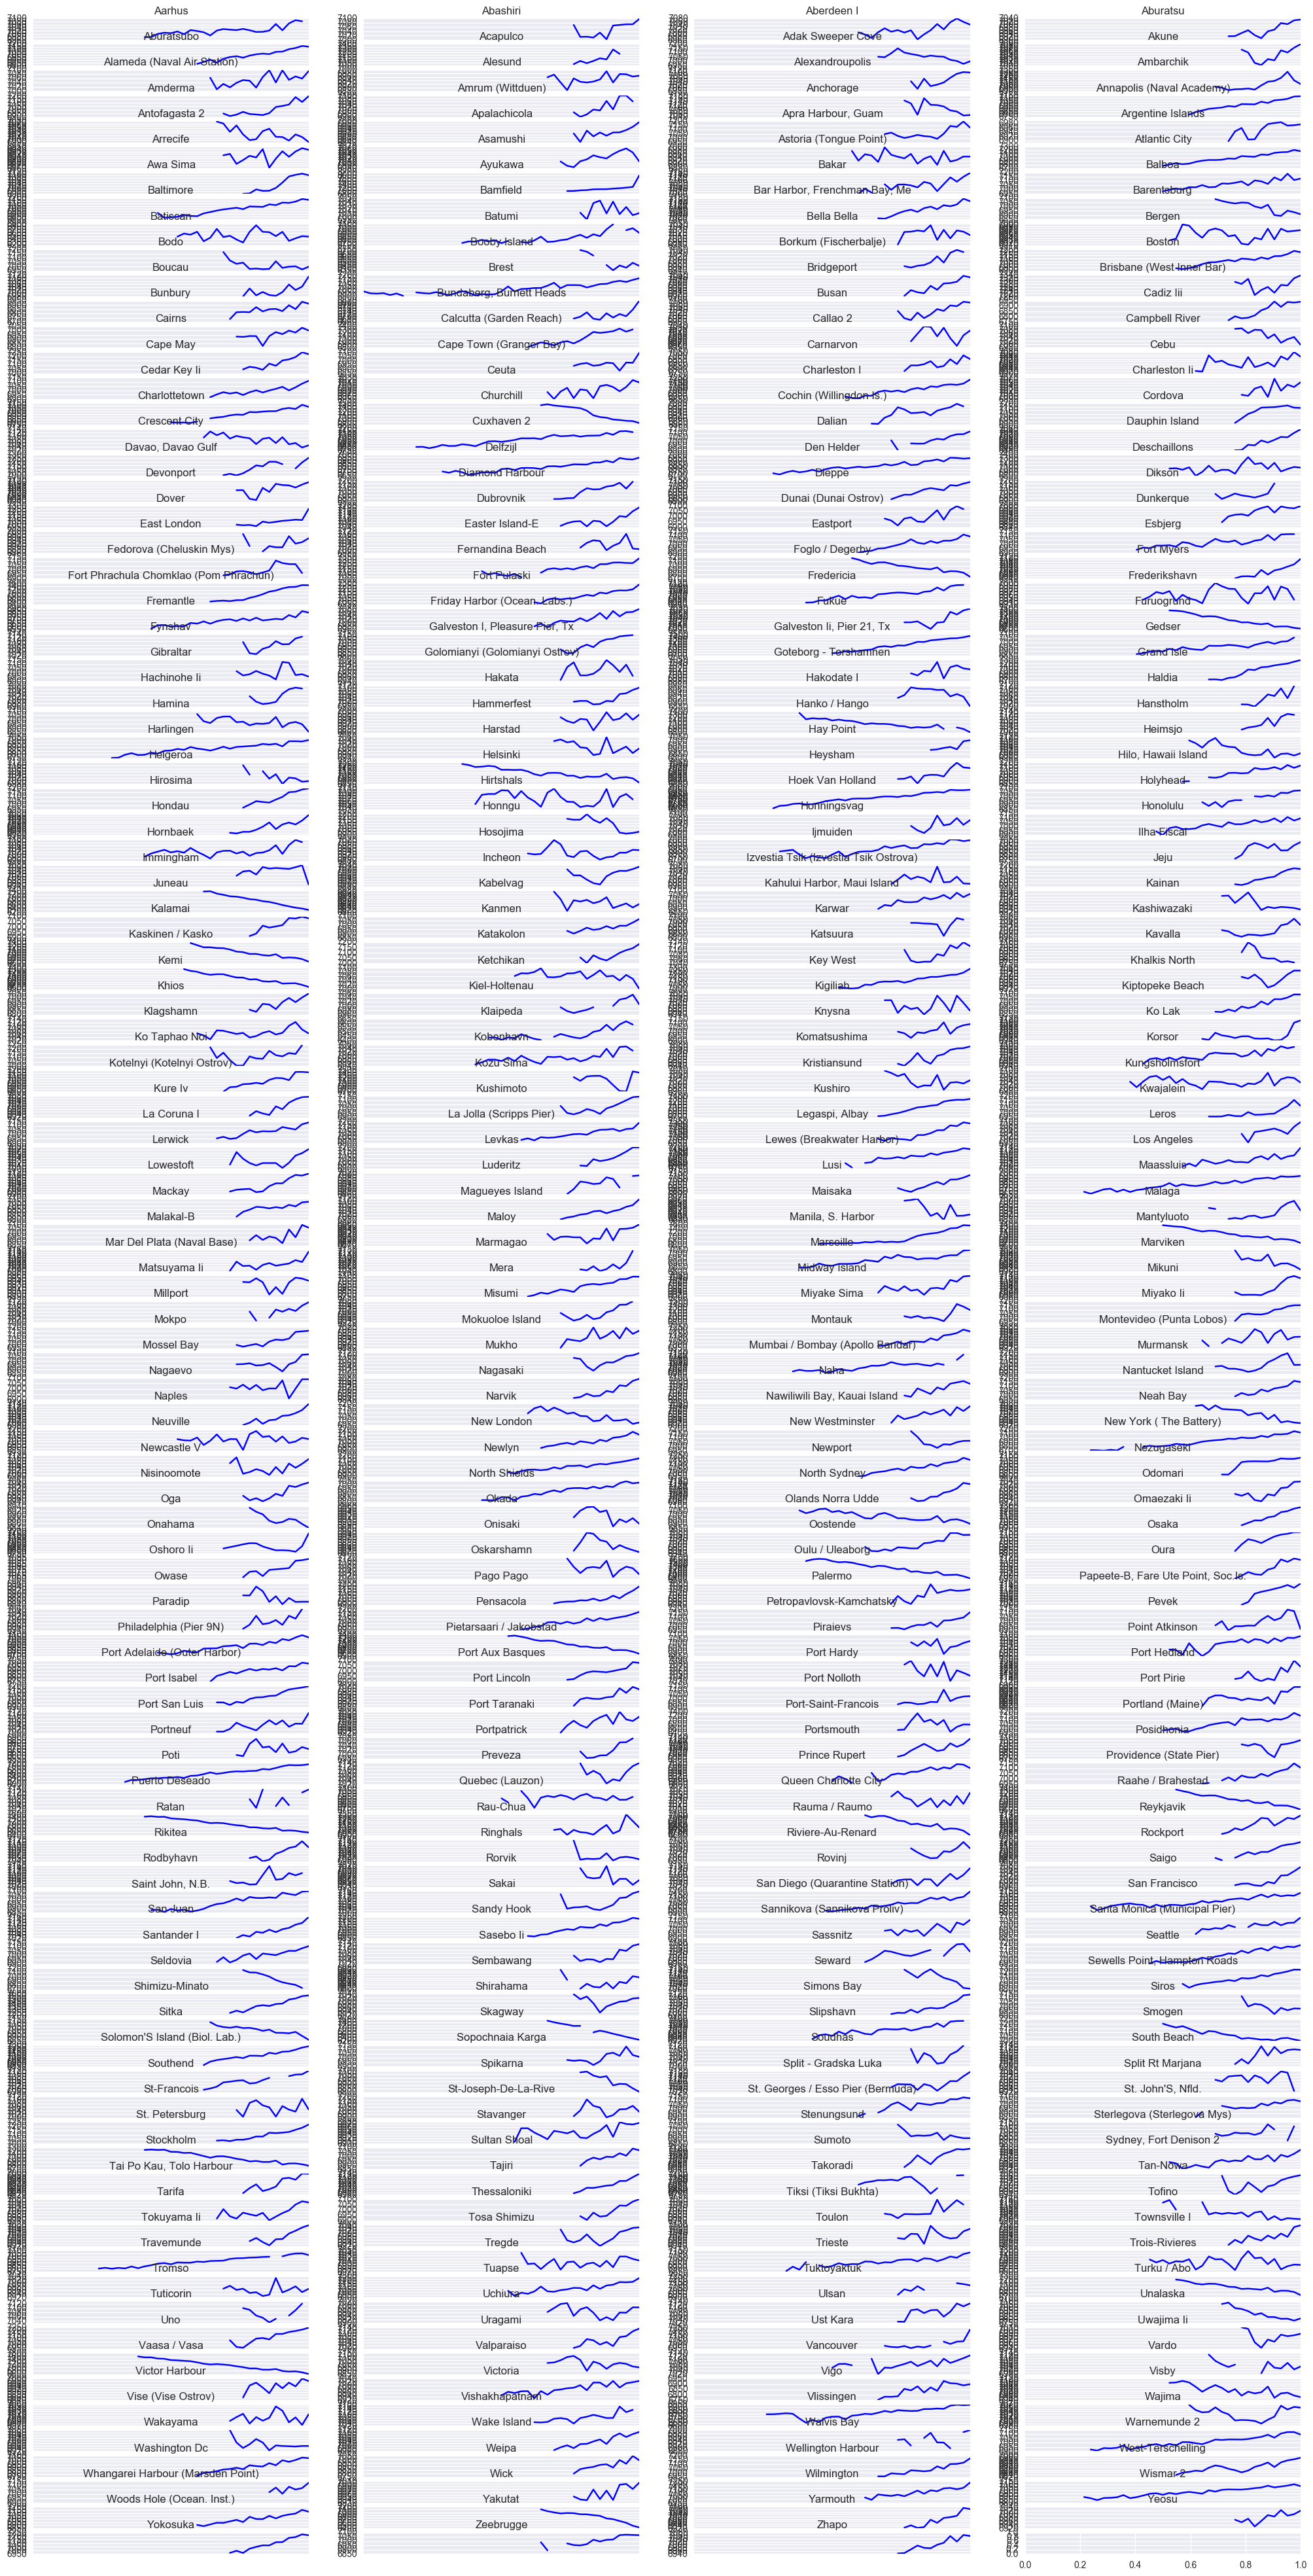

In [28]:
def plot_grid(df, cols=4, **kwargs):
    fig, axes = plt.subplots(nrows=int(np.ceil(len(df.columns) / cols)), ncols=cols)
    fig.set_figheight(30)
    fig.set_figwidth(40)

    for i, x in enumerate(df.columns):
        ax = axes[i // cols, i % cols]
        df[x].plot(ax=ax, color='blue', legend=False, label=False,
                   kind='line', stacked=False, sharex=False,
                   figsize=(25, 50))
        ax.set_title(x)
        ax.xaxis.set_visible(False)
    return fig

fig = plot_grid(data_subset_plot)
fig.show()


# Iceland

In [29]:
data_ISL = df[(df.Country == 'ISL')].groupby(['Location', 'timestamp']).tide.mean().unstack().T
data_ISL.tail()

Location    Grindavik  Reykjavik
timestamp                       
2015-08-01        NaN     7125.0
2015-09-01        NaN     7085.0
2015-10-01        NaN     7176.0
2015-11-01        NaN     7221.0
2015-12-01        NaN     7264.0

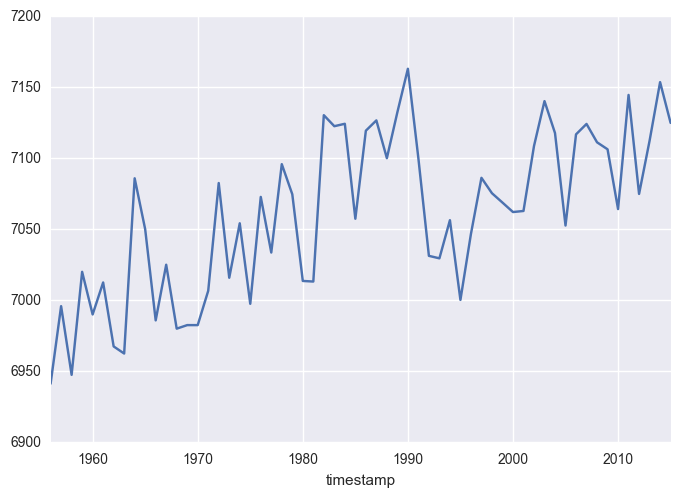

In [30]:
df[df.Location == 'Reykjavik'].set_index('timestamp').tide.resample('1A').mean().plot()

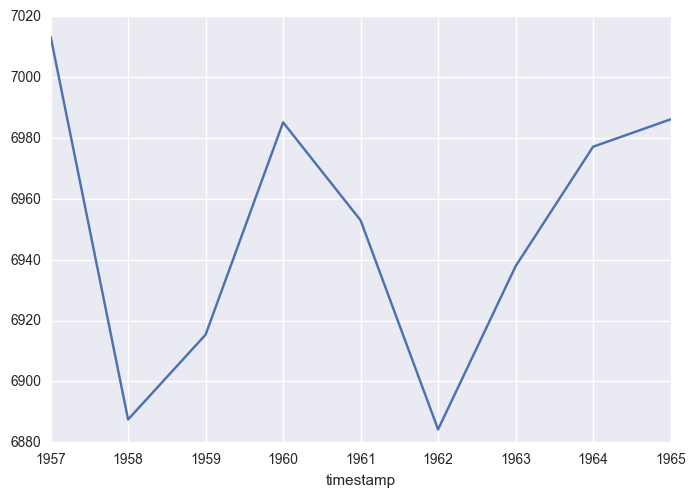

In [31]:
df[df.Location == 'Grindavik'].set_index('timestamp').tide.resample('1A').mean().plot()

# Philippines
26 tide gauges in the Philippines.

In [32]:
data_PHL = df[(df.Country == 'PHL')]

first_measurement_PHL = data_PHL.groupby(['Location']).timestamp.first()

first_measurement_PHL.sort_values()



Location
Manila, S. Harbor                1901-03-01
Cebu                             1935-05-01
Legaspi, Albay                   1947-05-01
Jolo, Sulu                       1947-11-01
Davao, Davao Gulf                1948-03-01
San Fernando, La Union           1948-04-01
Tacloban, Leyte                  1951-06-01
Port Irene                       1987-02-01
Surigao                          1987-05-01
San Jose                         1988-01-01
Puerto Princesa, Palawan         1990-07-01
Real Quezon                      2009-02-01
Balanacan, Marinduque            2011-01-01
Tandag, Surigao Del Sur          2011-01-01
Subic Zambales                   2011-01-01
Pulupandan, Negros Occidental    2011-01-01
Mati, Davao Oriental             2011-01-01
Virac, Catanduanes               2011-01-01
Mambajao Camguin                 2011-01-01
Makar, General Santos City       2011-01-01
Currimao Ilocos Norte            2011-01-01
Caticlan Malay Aklan             2011-01-01
Balintang, Quezon, Pala

timestamp
1951-12-31    6999.142857
1952-12-31    6995.700000
1953-12-31    6994.285714
1954-12-31    7058.272727
1955-12-31    7060.500000
Freq: A-DEC, Name: tide, dtype: float64

timestamp
1972-12-31    6983.666667
1973-12-31    6971.636364
1974-12-31    7040.666667
1975-12-31    7092.333333
1976-12-31    7027.333333
Freq: A-DEC, Name: tide, dtype: float64

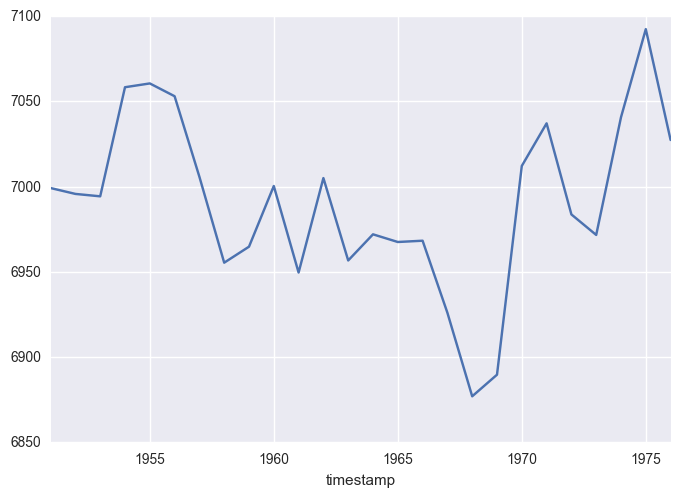

In [33]:
df[df.Location == 'Tacloban, Leyte'].set_index('timestamp').tide.resample('1A').mean().plot()
df[df.Location == 'Tacloban, Leyte'].set_index('timestamp').tide.resample('1A').mean().head()
df[df.Location == 'Tacloban, Leyte'].set_index('timestamp').tide.resample('1A').mean().tail()

In [34]:
data_PHL = df[(df.Country == 'PHL')].groupby(['Location', 'timestamp']).tide.mean().unstack().T

data_PHL = data_PHL.resample("1A").mean().apply(np.round)

data_PHL.tail()

Location    Balanacan, Marinduque  Balintang, Quezon, Palawan  \
timestamp                                                       
2010-12-31                    NaN                         NaN   
2011-12-31                 7029.0                      6990.0   
2012-12-31                 7064.0                      7009.0   
2013-12-31                 7050.0                         NaN   
2014-12-31                 6908.0                         NaN   

Location    Caticlan Malay Aklan    Cebu  Currimao Ilocos Norte  \
timestamp                                                         
2010-12-31                   NaN  7066.0                    NaN   
2011-12-31                6988.0  7081.0                 7018.0   
2012-12-31                7000.0  7114.0                 7116.0   
2013-12-31                6850.0  7082.0                 7107.0   
2014-12-31                6827.0  6914.0                 6931.0   

Location    Davao, Davao Gulf  Jolo, Sulu  Legaspi, Albay  \
timestamp                                                   
2010-12-31             7123.0         NaN          7283.0   
2011-12-31             7192.0         NaN          7345.0   
2012-12-31             7216.0         NaN          7385.0   
2013-12-31             7257.0         NaN          7365.0   
2014-12-31             7254.0         NaN          7268.0   

Location    Macabalan Port, Cagayan De Oro  Makar, General Santos City  \
timestamp                                                                
2010-12-31                             NaN                         NaN   
2011-12-31                          6940.0                      7006.0   
2012-12-31                          6962.0                      7059.0   
2013-12-31                          6981.0                      7098.0   
2014-12-31                          6935.0                      7041.0   

Location         ...        Pulupandan, Negros Occidental  Real Quezon  \
timestamp        ...                                                     
2010-12-31       ...                                  NaN       7100.0   
2011-12-31       ...                               6954.0       7108.0   
2012-12-31       ...                                  NaN       7187.0   
2013-12-31       ...                               6988.0       7136.0   
2014-12-31       ...                               6936.0       7164.0   

Location    San Fernando, La Union  San Jose  Subic Zambales  Surigao  \
timestamp                                                               
2010-12-31                     NaN    7078.0             NaN   7135.0   
2011-12-31                     NaN    7133.0          6954.0   7112.0   
2012-12-31                     NaN    7137.0          6979.0   7148.0   
2013-12-31                     NaN    7128.0          6820.0   7147.0   
2014-12-31                     NaN    7057.0          6799.0   7080.0   

Location    Tacloban, Leyte  Tandag, Surigao Del Sur  Virac, Catanduanes  \
timestamp                                                                  
2010-12-31              NaN                      NaN                 NaN   
2011-12-31              NaN                   6958.0              6990.0   
2012-12-31              NaN                   7068.0                 NaN   
2013-12-31              NaN                   7065.0              7159.0   
2014-12-31              NaN                   6934.0              7108.0   

Location    Zamboanga City  
timestamp                   
2010-12-31             NaN  
2011-12-31          7027.0  
2012-12-31          7055.0  
2013-12-31          7005.0  
2014-12-31          6896.0  

[5 rows x 26 columns]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


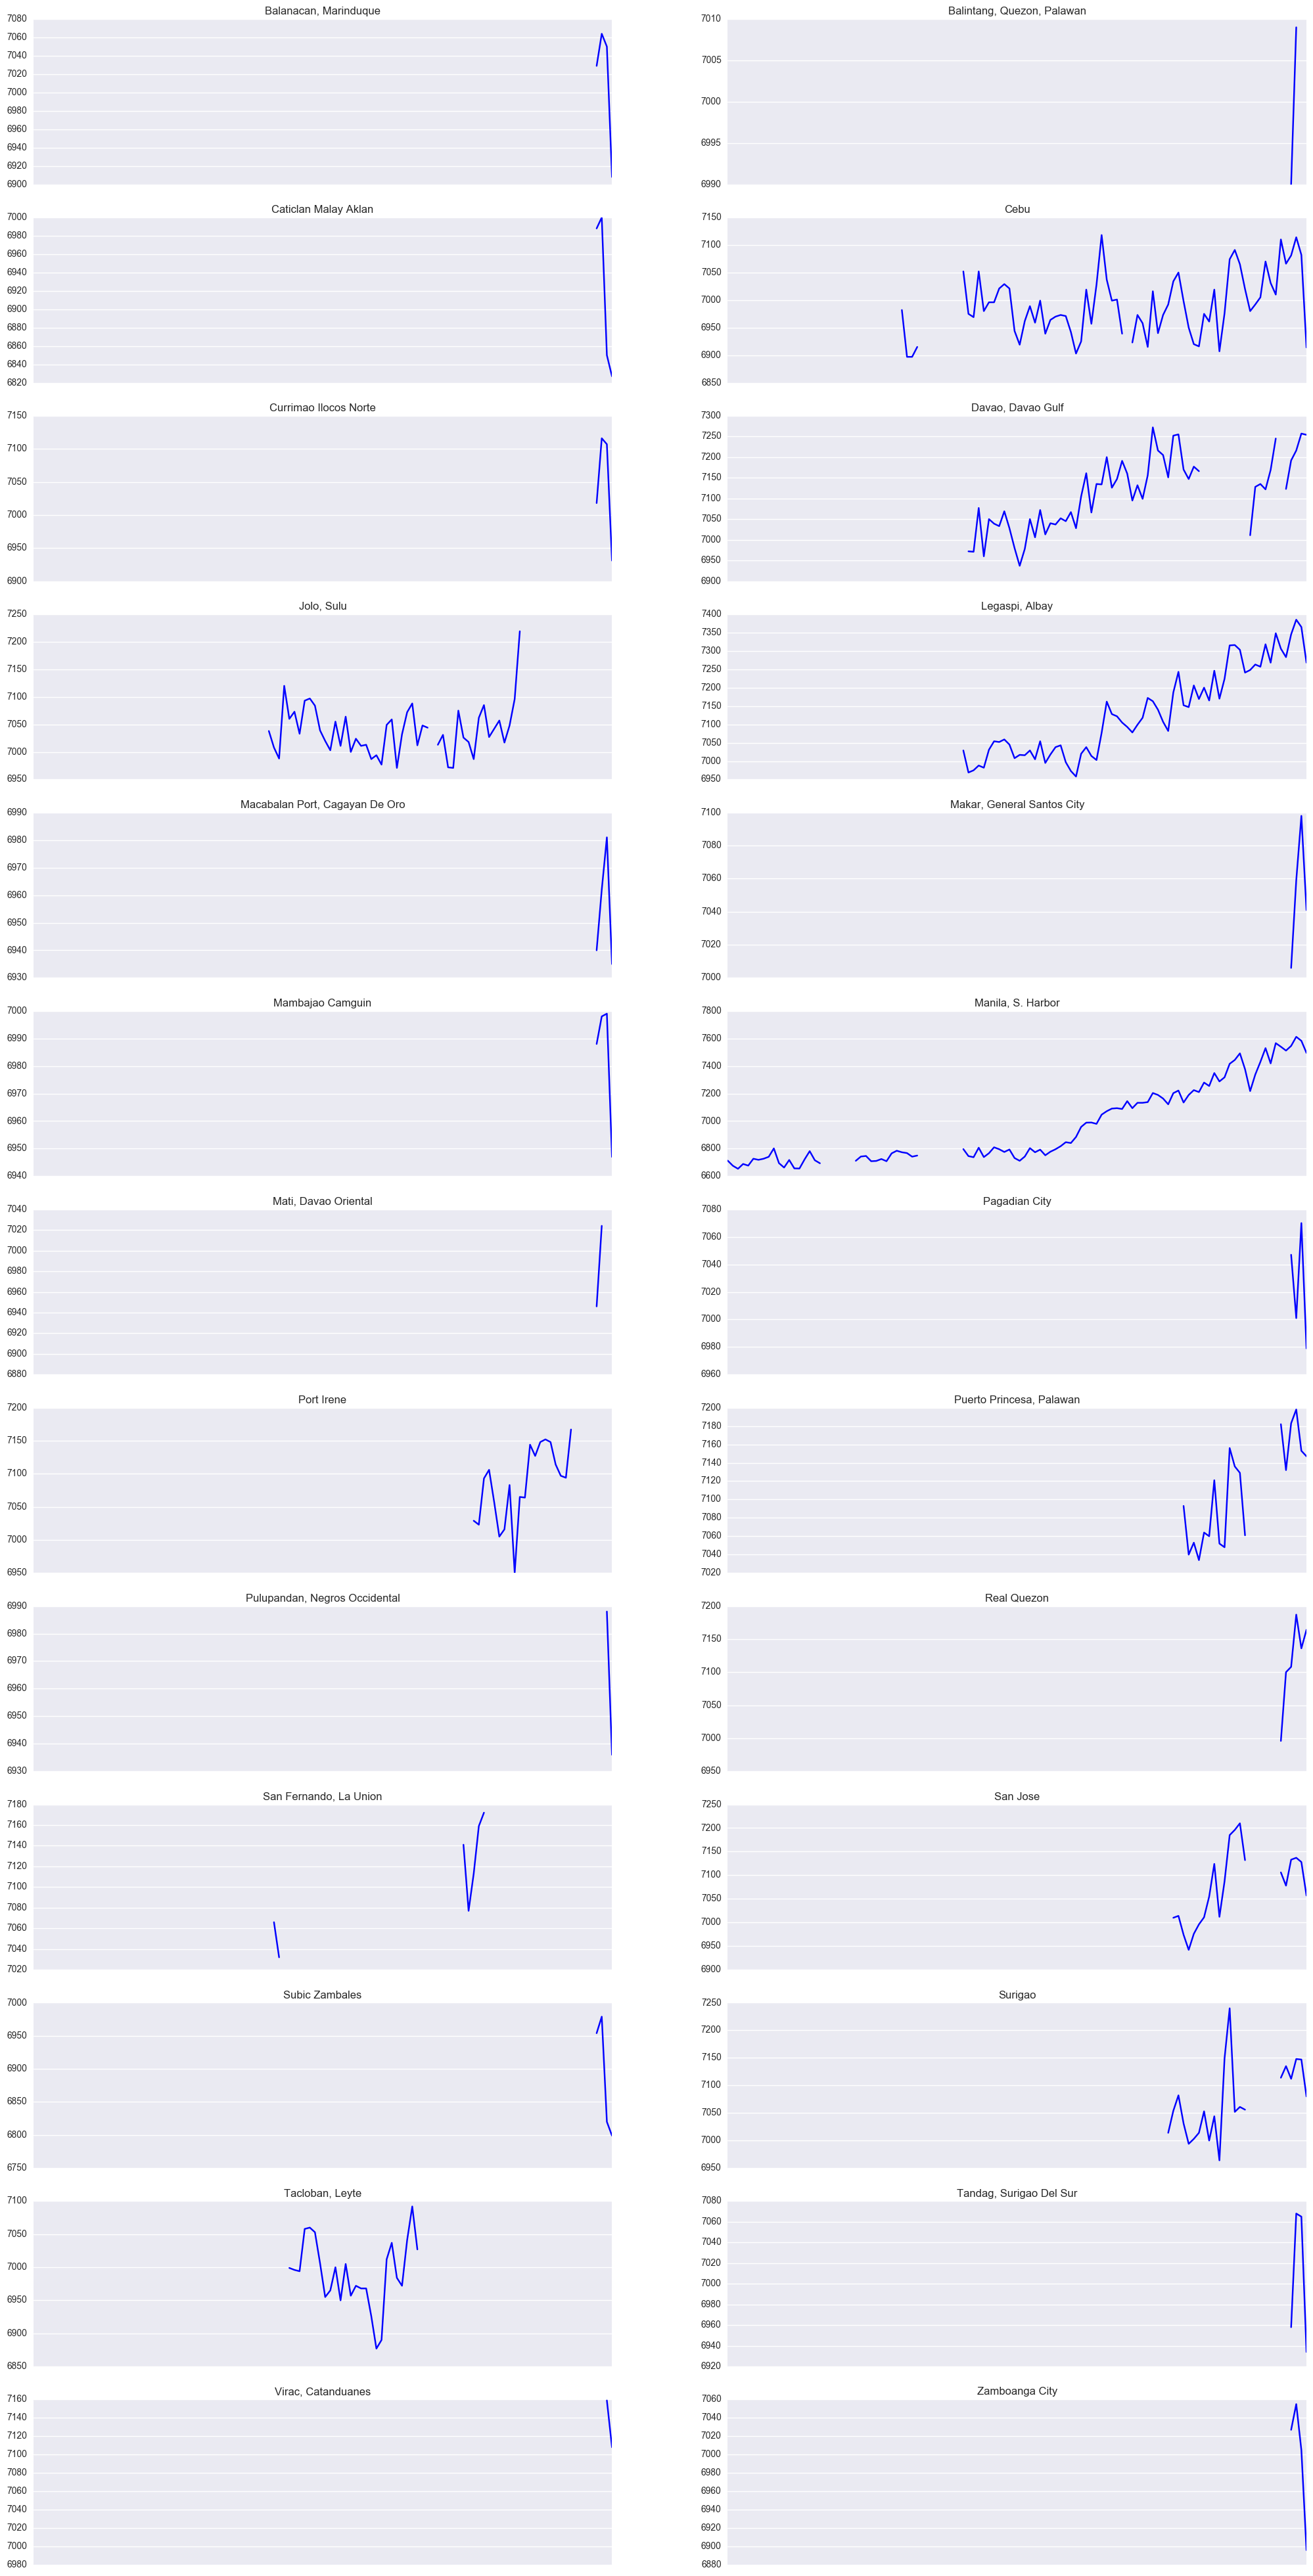

In [35]:
def plot_grid_small(df, cols=2, **kwargs):
    fig, axes = plt.subplots(nrows=int(np.ceil(len(df.columns) / cols)), ncols=cols)
    fig.set_figheight(6)
    fig.set_figwidth(8)

    for i, x in enumerate(df.columns):
        ax = axes[i // cols, i % cols]
        df[x].plot(ax=ax, color='blue', legend=False, label=False,
                   kind='line', stacked=False, sharex=False,
                   figsize=(25, 50))
        ax.set_title(x)
        ax.xaxis.set_visible(False)
    return fig


fig = plot_grid_small(data_PHL)
fig.show()


## Export Datasets for Map Visualization

In [19]:
#Use trend data from PSMSL to filter dataset

trends_1961_2011 = pd.read_csv('data/psmsl_data/trends_1961_2011.csv', header=0, usecols=[0,1,2,3,4,7], names=['Location', 'Latitude', 'Longitude', 'Country', 'trend', 'ID']) 
trends_1985_2014 = pd.read_csv('data/psmsl_data/trends_1985_2014.csv', header=0,usecols=[0,1,2,3,4,7], names=['Location', 'Latitude', 'Longitude', 'Country', 'trend', 'ID']) 


trends_1961_2011['Location'] = trends_1961_2011['Location'].apply(convert_location_names)
trends_1961_2011['Country'] = trends_1961_2011['Country'].apply(convert_location_names)

pd.qcut(trends_1961_2011['trend'], 5)
len(trends_1961_2011)

0         (1.364, 1.961]
1        (-0.185, 1.364]
2         (1.961, 2.951]
3         (1.364, 1.961]
4         (1.364, 1.961]
5         (1.364, 1.961]
6         (1.364, 1.961]
7         (2.951, 8.917]
8         (1.364, 1.961]
9      [-18.154, -0.185]
10        (1.364, 1.961]
11        (1.961, 2.951]
12        (1.364, 1.961]
13        (1.961, 2.951]
14        (1.364, 1.961]
15        (1.364, 1.961]
16     [-18.154, -0.185]
17        (2.951, 8.917]
18     [-18.154, -0.185]
19       (-0.185, 1.364]
20     [-18.154, -0.185]
21       (-0.185, 1.364]
22        (1.364, 1.961]
23     [-18.154, -0.185]
24        (1.961, 2.951]
25     [-18.154, -0.185]
26     [-18.154, -0.185]
27       (-0.185, 1.364]
28     [-18.154, -0.185]
29       (-0.185, 1.364]
30     [-18.154, -0.185]
31     [-18.154, -0.185]
32        (1.961, 2.951]
33        (1.364, 1.961]
34        (1.364, 1.961]
35     [-18.154, -0.185]
36       (-0.185, 1.364]
37       (-0.185, 1.364]
38        (1.364, 1.961]
39        (1.961, 2.951]


365

In [17]:
def yearly_mean(dataframe):
    
    mean_dataframe = dataframe.set_index('timestamp').tide.resample('1A').mean()
    mean_dataframe = mean_dataframe.reset_index()
    
    return pd.DataFrame(mean_dataframe)

def rolling_mean(dataframe):
    
    mean_dataframe = dataframe.set_index('timestamp').tide.resample('1A').mean()

    mean_dataframe = mean_dataframe.rolling(center=False, window=5, min_periods=1).mean()
    mean_dataframe = mean_dataframe.reset_index()
    
    
    return pd.DataFrame(mean_dataframe)


normal = df.groupby(['ID']).apply(yearly_mean)

rolling = df.groupby(['ID']).apply(rolling_mean)

normal.head()

rolling.head()

timestamp         tide
ID                          
1  0 1807-12-31  6970.333333
   1 1808-12-31  6867.333333
   2 1809-12-31  6954.916667
   3 1810-12-31  6946.416667
   4 1811-12-31  6977.166667

timestamp         tide
ID                          
1  0 1807-12-31  6970.333333
   1 1808-12-31  6918.833333
   2 1809-12-31  6930.861111
   3 1810-12-31  6934.750000
   4 1811-12-31  6943.233333

In [29]:
#delete rows which are not used for visualization

data_subset_viz = data_subset_1985_2014_clean.drop(['missing day','flag for attention', 'gloss id', 'coastline', 'flag', 'station', 'date'], 1)

data_subset_viz = data_subset_viz.groupby(['ID']).apply(rolling_mean)

data_subset_viz = data_subset_viz.reset_index()

#delete rows which are not used for visualization

data_subset_viz = data_subset_viz.drop(['level_1'], 1)

#filter by trend data
#data_subset_viz = data_subset_viz.merge(trends_1985_2014, left_on='ID', right_on='ID')

#add worldbank data
#data_subset_viz = data_subset_viz.merge(worldbank_data, left_on='ID', right_on='ID')

data_subset_viz = data_subset_viz.round()

data_subset_viz.head()
data_subset_viz['ID'].nunique()

ID  timestamp    tide
0   1 1807-12-31  6970.0
1   1 1808-12-31  6919.0
2   1 1809-12-31  6931.0
3   1 1810-12-31  6935.0
4   1 1811-12-31  6943.0

509

#### Use only for map animation in order to reduce data to 30 years

In [30]:
data_subset_viz = data_subset_viz.set_index(['timestamp'])

data_subset_viz = data_subset_viz.loc['1985-12-31':'2015-12-31']

data_subset_viz = data_subset_viz.reset_index()

#data_subset_viz.sort_values('timestamp', ascending=False)

data_subset_viz['ID'].nunique()

509

#### Add geodata and meta data again

In [31]:
data_subset_viz = data_subset_viz.merge(stations, left_on='ID', right_on='id')

data_subset_viz = data_subset_viz.drop(['gloss id', 'coastline', 'flag', 'station', 'date', 'id'], 1)

data_subset_viz['year'] = data_subset_viz.timestamp.dt.year

data_subset_viz

timestamp    ID    tide                  location  latitude  longitude  \
0     1985-12-31     1  7069.0                     Brest    48.383     -4.495   
1     1986-12-31     1  7068.0                     Brest    48.383     -4.495   
2     1987-12-31     1  7073.0                     Brest    48.383     -4.495   
3     1988-12-31     1  7078.0                     Brest    48.383     -4.495   
4     1989-12-31     1  7084.0                     Brest    48.383     -4.495   
5     1990-12-31     1  7085.0                     Brest    48.383     -4.495   
6     1991-12-31     1  7084.0                     Brest    48.383     -4.495   
7     1992-12-31     1  7077.0                     Brest    48.383     -4.495   
8     1993-12-31     1  7074.0                     Brest    48.383     -4.495   
9     1994-12-31     1  7076.0                     Brest    48.383     -4.495   
10    1995-12-31     1  7082.0                     Brest    48.383     -4.495   
11    1996-12-31     1  7093.0                     Brest    48.383     -4.495   
12    1997-12-31     1  7104.0                     Brest    48.383     -4.495   
13    1998-12-31     1  7107.0                     Brest    48.383     -4.495   
14    1999-12-31     1  7106.0                     Brest    48.383     -4.495   
15    2000-12-31     1  7110.0                     Brest    48.383     -4.495   
16    2001-12-31     1  7114.0                     Brest    48.383     -4.495   
17    2002-12-31     1  7119.0                     Brest    48.383     -4.495   
18    2003-12-31     1  7124.0                     Brest    48.383     -4.495   
19    2004-12-31     1  7125.0                     Brest    48.383     -4.495   
20    2005-12-31     1  7113.0                     Brest    48.383     -4.495   
21    2006-12-31     1  7109.0                     Brest    48.383     -4.495   
22    2007-12-31     1  7103.0                     Brest    48.383     -4.495   
23    2008-12-31     1  7105.0                     Brest    48.383     -4.495   
24    2009-12-31     1  7110.0                     Brest    48.383     -4.495   
25    2010-12-31     1  7127.0                     Brest    48.383     -4.495   
26    2011-12-31     1  7128.0                     Brest    48.383     -4.495   
27    2012-12-31     1  7132.0                     Brest    48.383     -4.495   
28    2013-12-31     1  7134.0                     Brest    48.383     -4.495   
29    2014-12-31     1  7146.0                     Brest    48.383     -4.495   
30    2015-12-31     1  7139.0                     Brest    48.383     -4.495   
31    1985-12-31     5  7007.0                  Holyhead    53.314     -4.620   
32    1986-12-31     5  7002.0                  Holyhead    53.314     -4.620   
33    1987-12-31     5  6999.0                  Holyhead    53.314     -4.620   
34    1988-12-31     5  7000.0                  Holyhead    53.314     -4.620   
35    1989-12-31     5  7011.0                  Holyhead    53.314     -4.620   
36    1990-12-31     5  7016.0                  Holyhead    53.314     -4.620   
37    1991-12-31     5  7010.0                  Holyhead    53.314     -4.620   
38    1992-12-31     5  7011.0                  Holyhead    53.314     -4.620   
39    1993-12-31     5  7008.0                  Holyhead    53.314     -4.620   
40    1994-12-31     5  6988.0                  Holyhead    53.314     -4.620   
41    1995-12-31     5  6977.0                  Holyhead    53.314     -4.620   
42    1996-12-31     5  6997.0                  Holyhead    53.314     -4.620   
43    1997-12-31     5  7002.0                  Holyhead    53.314     -4.620   
44    1998-12-31     5  7002.0                  Holyhead    53.314     -4.620   
45    1999-12-31     5  7010.0                  Holyhead    53.314     -4.620   
46    2000-12-31     5  7024.0                  Holyhead    53.314     -4.620   
47    2001-12-31     5  7034.0                  Holyhead    53.314     -4.620   
48    2002-12-31     5  7046.0        

In [32]:
data_subset_viz = data_subset_viz.groupby(['ID']).apply(to_zero)

In [33]:
data_strongest_rise = data_subset_viz[(data_subset_viz['year'] == 2015)]

In [42]:
data_strongest_rise = data_strongest_rise.sort_values('tide', ascending=False)

In [43]:
data_strongest_rise.to_csv('top_ten_landrise.csv')

#### Convert year to object to get rid of 1985.0

In [34]:
data_subset_viz['year'] = data_subset_viz['year'].astype(object)

data_subset_viz.dtypes

timestamp       datetime64[ns]
ID                       int64
tide                   float64
continent               object
iso3                    object
emission               float64
gdp                    float64
pop                    float64
pop_sealevel           float64
location                object
latitude               float64
longitude              float64
country                 object
year                    object
dtype: object

In [25]:
#function to use first tide measurement as zero reference point

def to_zero(dataframe):
    first_value = dataframe['tide'].iloc[0]
    dataframe['tide'] = dataframe['tide'] - first_value
    return dataframe

In [24]:
data_subset_viz = data_subset_viz.groupby(['ID']).apply(to_zero)
data_subset_viz['ID'].nunique()

509

In [25]:
data_subset_viz.to_csv('sealevel_viz_psmsl_dataset.csv')

In [37]:
tidedata_series = (data_subset_viz.groupby(['ID'])
       .apply(lambda x: x[['year','tide']].to_dict('r'))
       .rename(columns={0:'tideData'}))
tidedata_series

ID
1       [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
5       [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
7       [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
8       [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
9       [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
10      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
11      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
12      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
14      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
20      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
22      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
23      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
24      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
25      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
32      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
33      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
41      [{'year': 1985, 'tide': 0.0}, {'year': 1985, '...
45      [{'

In [38]:
cols = "ID location	latitude	longitude	country	emission	gdp	pop	pop_sealevel	continent".split()
j = data_subset_viz[cols].groupby("ID").first()
       #.to_json(orient='records', date_format='iso'))
j["tideData"] = tidedata_series
j = j.reset_index()
j = j.to_json(orient='records')

In [39]:
with open('data/subsets/mapanimation.json', 'w') as fp:
    json.dump(json.loads(j), fp, indent=2, sort_keys=True)

print(json.dumps(json.loads(j), indent=2, sort_keys=True))

[
  {
    "ID": 1,
    "continent": "Europe",
    "country": "FRA",
    "emission": 5.0,
    "gdp": 2418835532882.0,
    "latitude": 48.383,
    "location": "Brest",
    "longitude": -4.495,
    "pop": 66808385.0,
    "pop_sealevel": 3.0,
    "tideData": [
      {
        "tide": 0.0,
        "year": 1985
      },
      {
        "tide": -1.0,
        "year": 1986
      },
      {
        "tide": 4.0,
        "year": 1987
      },
      {
        "tide": 9.0,
        "year": 1988
      },
      {
        "tide": 15.0,
        "year": 1989
      },
      {
        "tide": 16.0,
        "year": 1990
      },
      {
        "tide": 15.0,
        "year": 1991
      },
      {
        "tide": 8.0,
        "year": 1992
      },
      {
        "tide": 5.0,
        "year": 1993
      },
      {
        "tide": 7.0,
        "year": 1994
      },
      {
        "tide": 13.0,
        "year": 1995
      },
      {
        "tide": 24.0,
        "year": 1996
      },
      {
        "tide": 35.0,

### Create subsets for countries

In [5]:
def save_country_subset(df, country):
    filename = 'data/sealevel_subset_' + str(country) + '.csv'
    data = df[(df.Country == country)]
    data.to_csv(filename, encoding='utf-8')
    return data



In [ ]:
df_us = save_country_subset(df, 'ARG')

df_phl = df_phl.groupby(['ID']).apply(rolling_mean)

df_phl = df_phl.reset_index()

df_phl = df_phl.drop(['level_1'], 1)

df_phl = df_phl.groupby(['ID']).apply(to_zero)

df_phl = df_phl.merge(stations, left_on='ID', right_on='id')

df_phl.to_csv('data/sealevel_subset_ISL.csv', encoding='utf-8')

In [6]:
save_country_subset(df, 'GEO')

tide  missing day flag for attention  timestamp  ID Location  \
221346  5999.0            0                000 1874-01-01  41     POTI   
221347  5939.0            0                000 1874-02-01  41     POTI   
221348  5929.0            0                000 1874-03-01  41     POTI   
221349  5999.0            0                000 1874-04-01  41     POTI   
221350  6099.0            0                000 1874-05-01  41     POTI   
221351  6249.0            0                000 1874-06-01  41     POTI   
221352  6149.0            0                000 1874-07-01  41     POTI   
221353  6049.0            0                000 1874-08-01  41     POTI   
221354  5919.0            0                000 1874-09-01  41     POTI   
221355  5829.0            0                000 1874-10-01  41     POTI   
221356  5819.0            0                000 1874-11-01  41     POTI   
221357  6009.0            0                000 1874-12-01  41     POTI   
221358  6059.0            0                000 1875-01-01  41     POTI   
221359  6099.0            0                000 1875-02-01  41     POTI   
221360  6099.0            0                000 1875-03-01  41     POTI   
221361  6129.0            0                000 1875-04-01  41     POTI   
221362  6179.0            0                000 1875-05-01  41     POTI   
221363  6219.0            0                000 1875-06-01  41     POTI   
221364  6189.0            0                000 1875-07-01  41     POTI   
221365  6199.0            0                000 1875-08-01  41     POTI   
221366  6099.0            0                000 1875-09-01  41     POTI   
221367  6059.0            0                000 1875-10-01  41     POTI   
221368  6189.0            0                000 1875-11-01  41     POTI   
221369  6229.0            0                000 1875-12-01  41     POTI   
221370  6069.0            0                000 1876-01-01  41     POTI   
221371  6029.0            0                000 1876-02-01  41     POTI   
221372  6179.0            0                000 1876-03-01  41     POTI   
221373  6159.0            0                000 1876-04-01  41     POTI   
221374  6269.0            0                000 1876-05-01  41     POTI   
221375  6239.0            0                000 1876-06-01  41     POTI   
221376  6259.0            0                000 1876-07-01  41     POTI   
221377  6149.0            0                000 1876-08-01  41     POTI   
221378  6099.0            0                000 1876-09-01  41     POTI   
221379  6029.0            0                000 1876-10-01  41     POTI   
221380  6159.0            0                000 1876-11-01  41     POTI   
221381  6219.0            0                000 1876-12-01  41     POTI   
221382  6219.0            0                000 1877-01-01  41     POTI   
221383  6199.0            0                000 1877-02-01  41     POTI   
221384  6229.0            0                000 1877-03-01  41     POTI   
221385  6369.0            0                000 1877-04-01  41     POTI   
221386  6429.0            0                000 1877-05-01  41     POTI   
221387  6439.0            0                000 1877-06-01  41     POTI   
221388  6359.0            0                000 1877-07-01  41     POTI   
221389  6259.0            0                000 1877-08-01  41     POTI   
221390  6129.0            0                000 1877-09-01  41     POTI   
221391  6049.0            0                000 1877-10-01  41     POTI   
221392  6049.0            0                000 1877-11-01  41     POTI   
221393  6089.0            0                000 1877-12-01  41     POTI   
221394  6229.0            0                000 1878-01-01  41     POTI   
221395  6099.0            0                000 1878-02-01  41     POTI   
221396  6169.0            0                000 1878-03-01  41     POTI   
221397  6409.0            0                000 1878-04-01  41     POTI   
221398  6379.0            0                000 1878-05-01  41     POTI   
221399  6359.0

In [45]:
def count_positives(df):
    counter = 0
    for index, row in df.iterrows():
        if row['trend'] < 0:
            counter += 1
    return counter

In [137]:
brest = df[(df.Location == 'Brest')]

brest['normalisiert'] = brest['tide']/brest['tide'].max().astype(np.float64)

brest = brest[['Latitude', 'Longitude', 'normalisiert', 'timestamp']]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [139]:
brest.to_csv('brest.csv')